In [ ]:
import functools
import itertools

import attr
import networkx


def relation_is_transitive(relation: networkx.Graph):
    return len(relation.edges()) == len(networkx.transitive_closure(relation).edges())


def relation_is_antisymmetric(relation: networkx.Graph):
    return len(relation) == len(networkx.condensation(relation))


def relation_is_reflexive(relation: networkx.Graph):
    return all(relation.has_successor(v, v) for v in relation)


def relation_is_poset(relation: networkx.Graph):
    return (
        relation_is_transitive(relation)
        and relation_is_antisymmetric(relation)
        and relation_is_reflexive(relation)
    )


@attr.s(frozen=True, slots=True)
class Poset:
    reduced = attr.ib()
    closed = attr.ib(validator=lambda self, attr, rel: relation_is_poset(rel))
    
    @classmethod
    def from_reduced(cls, reduced: networkx.DiGraph):
        assert networkx.is_directed_acyclic_graph(reduced)
        if not networkx.is_frozen(reduced):
            reduced = networkx.freeze(reduced.copy())
        closed = networkx.transitive_closure(reduced)
        closed.add_edges_from(zip(closed, closed))
        closed = networkx.freeze(closed)
        return cls(reduced=reduced, closed=closed)
    
    @classmethod
    def from_closed(cls, closed: networkx.DiGraph):
        reduced = closed.copy()
        if not networkx.is_frozen(closed):
            closed = networkx.freeze(closed.copy())
        reduced.remove_edges_from(zip(closed, closed))
        reduced = networkx.transitive_reduction(reduced)
        reduced = networkx.freeze(reduced)
        return cls(reduced=reduced, closed=closed)
    
    def subposet(self, removed_nodes):
        clo = self.closed.copy()
        clo.remove_nodes_from(removed_nodes)
        clo = networkx.convert_node_labels_to_integers(clo)
        return self.from_closed(clo)

    def upper_bounds(self, subset):
        return functools.reduce(
            set.intersection,
            map(self.closed.successors, subset),
            set(self.closed),
        )

    def lower_bounds(self, subset):
        return functools.reduce(
            set.intersection,
            map(self.closed.predecessors, subset),
            set(self.closed),
        )

    def supremum_candidates(self, subset):
        upper = self.upper_bounds(subset)
        lower = self.lower_bounds(upper)
        return upper & lower

    def supremum(self, subset):
        candidates = tuple(self.supremum_candidates(subset))
        assert 1 == len(candidates)
        return candidates[0]
    
    def is_join_semilattice(self):
        for i in self.closed:
            for j in self.closed:
                if i < j and 1 != len(self.supremum_candidates({i, j})):    
                    return False
        return True
    
    def is_meet_semilattice(self):
        return Poset(
            networkx.reverse_view(self.reduced),
            networkx.reverse_view(self.closed),
        ).is_join_semilattice()

    def is_lattice(self):
        return self.is_join_semilattice() and self.is_meet_semilattice()
    
    def join_irreducibles(self):
        return {node for node in self.reduced if 1 == self.reduced.out_degree(node)}

In [ ]:
MAX_LATTICE_WITH_4_IRREDUCIBLES = Poset.from_reduced(networkx.DiGraph(
    {
        0: [1, 2, 3, 4],
        1: [5, 6, 10],
        2: [5, 7, 8],
        3: [6, 7, 9],
        4: [10, 8, 9],
        5: [11, 12],
        6: [11, 13],
        7: [11, 14],
        8: [12, 14],
        9: [13, 14],
        10: [12, 13],
        11: [15],
        12: [15],
        13: [15],
        14: [15],
        15: [],
    },
))

assert MAX_LATTICE_WITH_4_IRREDUCIBLES.is_lattice()

In [ ]:
MAX_LATTICE_WITH_4_IRREDUCIBLES.join_irreducibles()

In [ ]:
def all_lattices_with_k_irreducibles(k: int):
    assert k <= 4
    
    result = []

    for size in range(len(MAX_LATTICE_WITH_4_IRREDUCIBLES.closed.nodes)):
        for combination in itertools.combinations(MAX_LATTICE_WITH_4_IRREDUCIBLES.closed.nodes, size):
            subposet = MAX_LATTICE_WITH_4_IRREDUCIBLES.subposet(combination)
            if (
                subposet.is_lattice()
                and k == len(subposet.join_irreducibles())
                and not any(networkx.is_isomorphic(subposet.reduced, old.reduced) for old in result)
            ):
                result.append(subposet)
    return result

In [ ]:
%%time
all_4_irred_lattices = all_lattices_with_k_irreducibles(4)

In [ ]:
assert 126 == len(all_4_irred_lattices)

In [ ]:
def draw_poset(poset: Poset, pos=None):
    networkx.draw_networkx(poset.reduced, pos=pos)

In [ ]:
def recover_all_positions(lattice: Poset, known_positions, irreducibles):
    top = [node for node in lattice.reduced if 0 == lattice.reduced.out_degree(node)][0]
    d = {node: lattice.reduced.out_degree(node) for node in lattice.reduced}
    
    result = dict(known_positions)
    result[top] = np.asarray([0., 0.])

    queue = collections.deque([top])
    visited = {top}
    delta_index = collections.Counter()
    while queue:
        cur = queue.popleft()
        for neigh in lattice.reduced.predecessors(cur):
            if neigh in visited:
                continue
            if neigh in result:
                if neigh in irreducibles:
                    delta_index[cur] += 1
                visited.add(neigh)
                queue.append(neigh)
                continue
            d[neigh] -= 1
            assert d[neigh] >= 0
            if 0 == d[neigh]:
                result[neigh] = sum(map(
                    result.__getitem__, 
                    (irreducibles - {neigh}) & set(lattice.closed.successors(neigh)),
                ))
                if neigh in irreducibles:
                    result[neigh] += np.asarray([0, -2]) + np.asarray([2, 0]) * delta_index[cur]
                    delta_index[cur] += 1
                visited.add(neigh)
                queue.append(neigh)
    assert len(result) == len(lattice.reduced.nodes)
    return result

In [ ]:
import collections
import numpy as np

def get_init_coordinates(lattice: Poset):
    top = [node for node in lattice.reduced if 0 == lattice.reduced.out_degree(node)][0]
    irred = frozenset(lattice.join_irreducibles())
    coatoms = [node for node in irred if lattice.reduced.has_edge(node, top)]
    result = {}
    result[top] = (0., 0.)
    coatom_point = lambda x: np.asarray((x, -0.09 * x**2 - 1.75))
    if len(coatoms) % 2:
        result[coatoms[0]] = coatom_point(0.)
        delta = -0.9
    else:
        delta = 0.
    for i, (a, b) in enumerate(zip(coatoms[1::2], coatoms[2 * (len(coatoms) % 2)::2]), 1):
        result[a] = coatom_point(i * 1.8 + delta)
        result[b] = coatom_point(-result[a][0])
        
    return recover_all_positions(lattice, result, irred)

In [ ]:
%matplotlib inline

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
for lat in all_4_irred_lattices[::30]:
    plt.figure()
    draw_poset(lat, pos=get_init_coordinates(lat))

In [30]:
import numpy as np

# from: https://gist.github.com/nim65s/5e9902cd67f094ce65b0
def point_line_distance(P, A, B):
    """ segment line AB, point P, where each one is an array([x, y]) """
    from numpy import arccos, array, dot, pi, cross
    from numpy.linalg import det, norm
    
    if all(A == P) or all(B == P):
        return 0
    if arccos(dot((P - A) / norm(P - A), (B - A) / norm(B - A))) > pi / 2:
        return norm(P - A)
    if arccos(dot((P - B) / norm(P - B), (A - B) / norm(A - B))) > pi / 2:
        return norm(P - B)
    return norm(cross(A-B, A-P))/norm(B-A)

def recover_positions_from_irred_pos(lattice, irred_pos, irreducibles):
    return recover_all_positions(
        lattice,
        dict(zip(irreducibles, irred_pos.reshape((len(irreducibles), 2)))),
        irreducibles,
    )

def energy(irred_pos, lattice):
    irreducibles = lattice.join_irreducibles()
    pos = recover_positions_from_irred_pos(lattice, irred_pos, irreducibles)  
    
    def repulsive(node):
        return 4 * sum(
            1. / point_line_distance(pos[node], pos[edge[0]], pos[edge[1]])
            for edge in lattice.reduced.edges
            if node not in edge
        )
        
    def attractive(node):
        return 4 * sum(
            ((pos[neigh] - pos[node]) ** 2).sum()
            for neigh in lattice.reduced.successors(node)
        )

    phi_0 = np.pi / (len(irreducibles) + 1)
    E_0 = -phi_0 - np.sin(phi_0) * np.cos(phi_0)
    E_1 = E_0 + np.pi
    def gravity(node):
        e_grav = 0.
        if node in irreducibles:
            for upper in lattice.reduced.successors(node):
                break
            edge_vector = pos[upper] - pos[node]
            phi = np.pi - np.arctan2(*edge_vector[::-1])
            e = phi + 1./ np.tan(phi) * np.sin(phi_0)**2
            if -np.pi / 2. <= phi <= phi_0:
                e_grav += e + E_0
            elif np.pi -  phi_0 <= phi or phi <= -np.pi / 2.:
                e_grav += -e + E_1
        return 12 * e_grav

    return sum(
        component(node)
        for node in lattice.closed
        for component in [attractive, gravity, repulsive]
    )

In [ ]:
def get_init_irreducible_coordinates(lattice: Poset):
    all = get_init_coordinates(lattice)
    res = np.asarray([all[i] for i in lattice.join_irreducibles()])
    return res.reshape((res.shape[0] * res.shape[1]))

energy(
    get_init_irreducible_coordinates(all_4_irred_lattices[-5]),
    all_4_irred_lattices[-5])

In [ ]:
import scipy.optimize
def get_optimal_pos(lattice):
    init = get_init_irreducible_coordinates(lattice)
    res = scipy.optimize.minimize(energy, init, args=(lattice,))
    return recover_positions_from_irred_pos(lattice, res.x, lattice.join_irreducibles())

In [ ]:
def draw_optimal(lattice):
    draw_poset(lattice, get_optimal_pos(lattice))

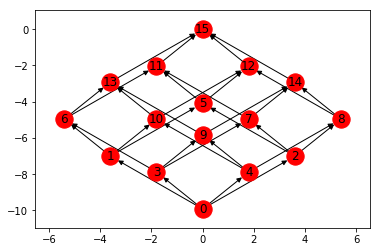

In [28]:
draw_poset(MAX_LATTICE_WITH_4_IRREDUCIBLES, get_init_coordinates(MAX_LATTICE_WITH_4_IRREDUCIBLES))

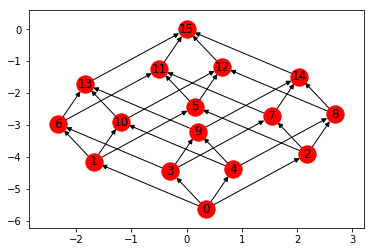

In [31]:
draw_optimal(MAX_LATTICE_WITH_4_IRREDUCIBLES)

CPU times: user 1min 24s, sys: 702 ms, total: 1min 25s
Wall time: 1min 24s


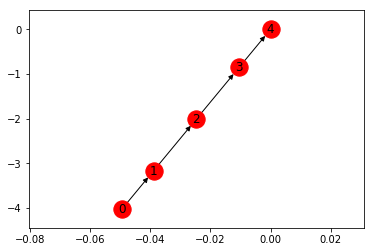

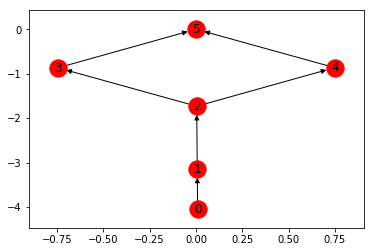

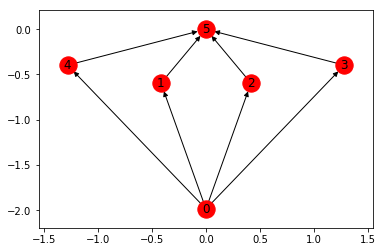

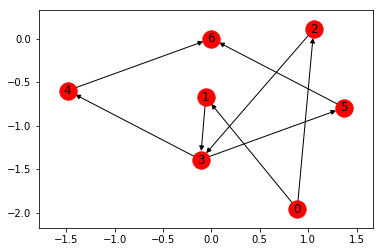

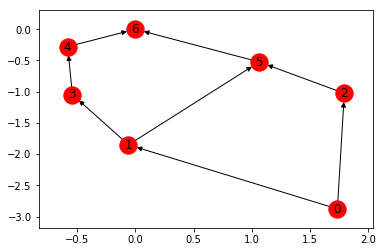

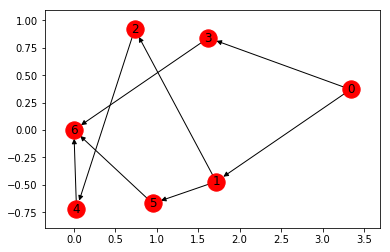

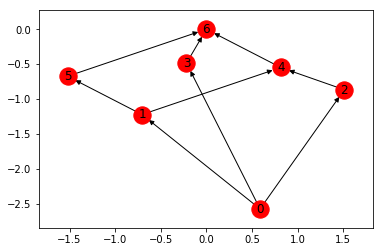

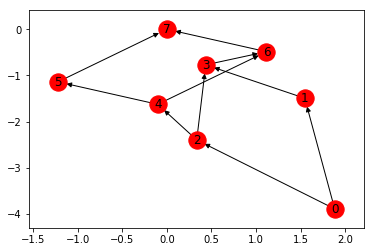

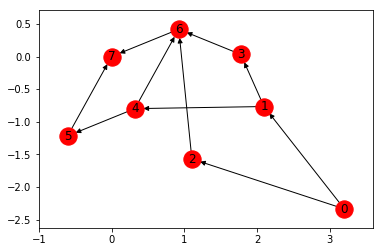

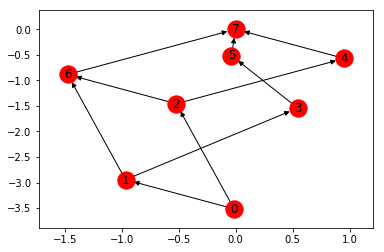

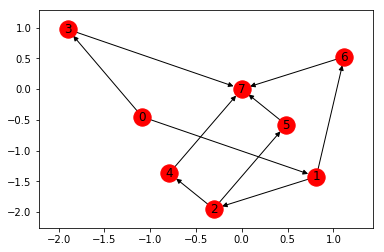

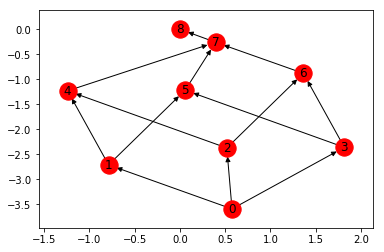

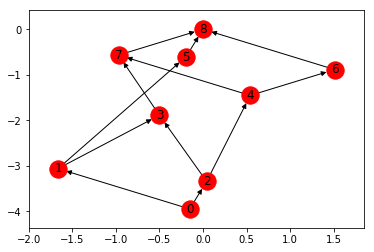

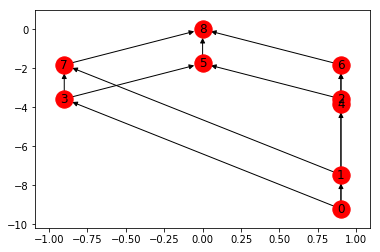

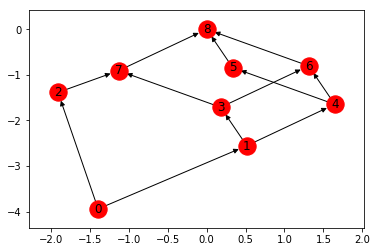

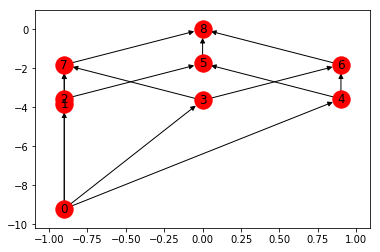

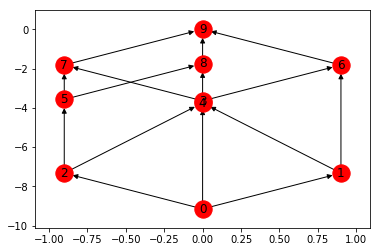

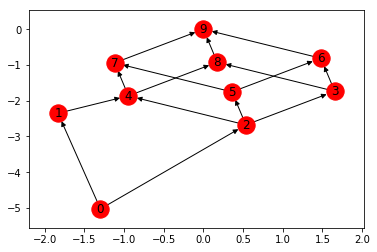

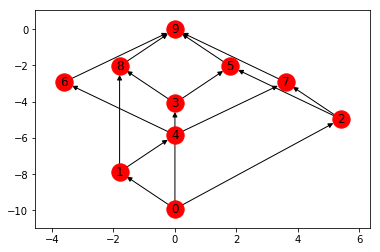

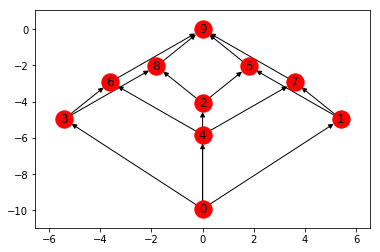

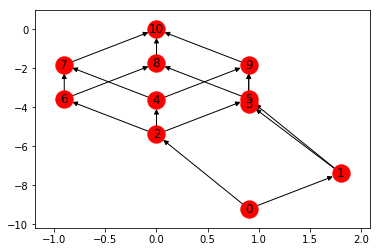

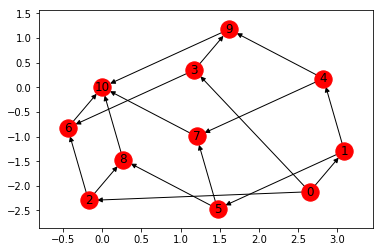

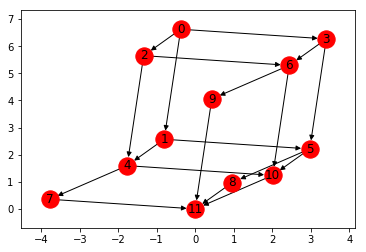

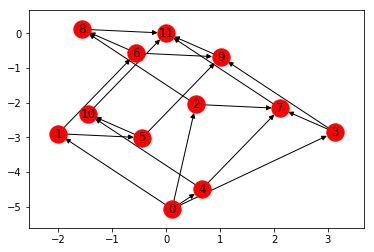

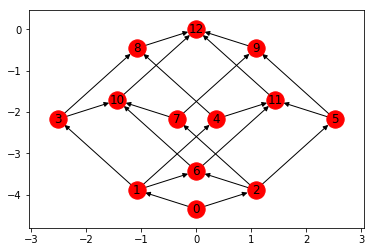

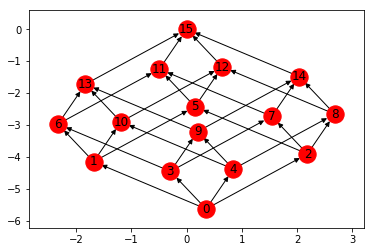

In [32]:
%%time
import warnings
warnings.filterwarnings("ignore")

for lat in all_4_irred_lattices[::-5]:
    plt.figure()
    draw_optimal(lat)